# Training an Unet

This notebook aims to train an Unet to make predictions based on the first 10 images in the dataset, located in data/data_rgb:
- 2022_06_20
- 2022_07_05
- 2022_07_15
- 2022_07_10
- 2022_07_25
- 2022_07_30
- 2022_08_04
- 2022_08_09
- 2022_08_14
- 2022_08_24
- 2022_09_03
- 2022_09_08
- 2022_09_13
- 2022_09_18
- 2022_10_13
- 2022_10_23
- 2022_12_02
- 2022_12_12



In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf


root_directory = "../data/data_rgb/2022_06_20"

y  = np.load(os.path.join(root_directory, 'y_input.npy'))
X  = np.load(os.path.join(root_directory, 'x_input.npy'))

print(X.shape)
print(y.shape)


(864, 250, 250, 5)
(864, 250, 250)


In [22]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if len(display_list[i].shape) == 3:
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    else:
        plt.imshow(display_list[i])
  plt.show()

(250, 250, 4)
(250, 250)


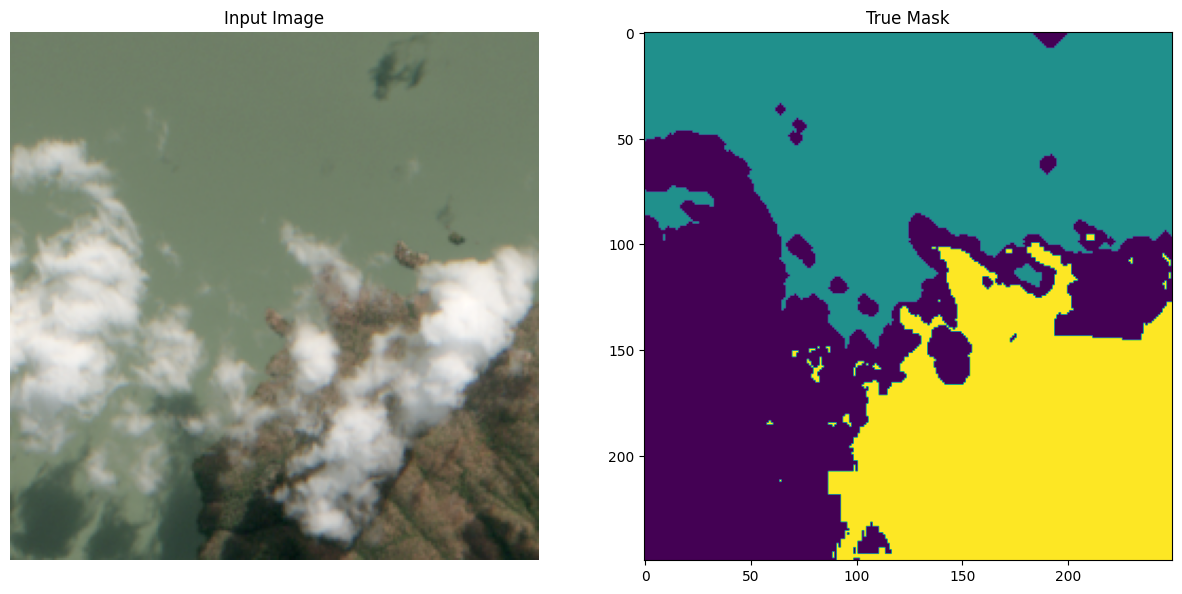

In [27]:
sample_image, sample_mask = X[5], y[5]
sample_image = sample_image[..., :4]
print(sample_image.shape)
print(sample_mask.shape)
display([sample_image, sample_mask])

### 1. Splitting the Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# example of 3 d image + mask image

### 2. Normalizing

In [ ]:
# one-hot-encoded labels ? shape of Y

### 3. Building the unet model

In [11]:
from models.unet_model import unet_2d
from keras.losses import categorical_crossentropy

model = unet_2d(input_shape=(256, 256, 4), num_classes=3)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_140 (Conv2D)            (None, 256, 256, 64  2368        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_141 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_140[0][0]']             
                                )                                                           

### 4. Training the model

In [12]:
model.compile(optimizer='adam',
              loss=categorical_crossentropy, # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### 5. Saving the model

### 6. Analyzing the results
- predifined success metrics
- printing loss and validation functions
- making predictions

### 7. Summary